In [1]:
from random import shuffle
from collections import Counter
import glob
%matplotlib inline
shuffle_data = True  # shuffle the addresses before saving
hdf5_path = '../data/processed/apple_avocado.hdf5'  # address to where you want to save the hdf5 file
data_path = '../data/external/*/*.jpg'
# read addresses and labels from the 'train' folder
addrs = glob.glob(data_path, recursive=True)
labels = [0 if 'Avocado' in addr else 1 for addr in addrs]
print(len(labels))
print(Counter(labels))

2447
Counter({1: 1426, 0: 1021})


In [2]:
# to shuffle data
if shuffle_data:
    c = list(zip(addrs, labels))
    shuffle(c)
    addrs, labels = zip(*c)
    
# Divide the data into 80% train, 20% validation
train_addrs = addrs[0:int(0.8*len(addrs))]
train_labels = labels[0:int(0.8*len(labels))]
val_addrs = addrs[int(0.8*len(addrs)):]
val_labels = labels[int(0.8*len(labels)):]

In [3]:
import numpy as np
import h5py
dt = h5py.special_dtype(vlen=str)     # PY3

data_order = 'tf'  # 'th' for Theano, 'tf' for Tensorflow
# check the order of data and chose proper data shape to save images
if data_order == 'th':
    train_shape = (len(train_addrs), 3, 224, 224)
    val_shape = (len(val_addrs), 3, 224, 224)
elif data_order == 'tf':
    train_shape = (len(train_addrs), 224, 224, 3)
    val_shape = (len(val_addrs), 224, 224, 3)
# open a hdf5 file and create earrays
hdf5_file = h5py.File(hdf5_path, mode='w')
hdf5_file.create_dataset("train_set_x", train_shape, np.int8)
hdf5_file.create_dataset("list_classes", (2,), dtype=dt)
hdf5_file.create_dataset("val_set_x", val_shape, np.int8)
hdf5_file.create_dataset("train_mean", train_shape[1:], np.float32)
hdf5_file.create_dataset("train_set_y", (len(train_addrs),), np.int8)
hdf5_file["train_set_y"][...] = train_labels
hdf5_file.create_dataset("val_set_y", (len(val_addrs),), np.int8)
hdf5_file["val_set_y"][...] = val_labels
hdf5_file["list_classes"][...] = ['avocado', 'apple']


In [4]:
import cv2
# a numpy array to save the mean of the images
mean = np.zeros(train_shape[1:], np.float32)
# loop over train addresses
for i in range(len(train_addrs)):
    # print how many images are saved every 1000 images
    if i % 10 == 0 and i > 1:
        print ('Train data: {}/{}'.format(i, len(train_addrs)))
    # read an image and resize to (224, 224)
    # cv2 load images as BGR, convert it to RGB
    addr = train_addrs[i]
    img = cv2.imread(addr)
    img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_CUBIC)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # add any image pre-processing here
    # if the data order is Theano, axis orders should change
    if data_order == 'th':
        img = np.rollaxis(img, 2)
    # save the image and calculate the mean so far
    hdf5_file["train_set_x"][i, ...] = img[None]
    mean += img / float(len(train_labels))
# loop over validation addresses
for i in range(len(val_addrs)):
    # print how many images are saved every 1000 images
    if i % 10 == 0 and i > 1:
        print ('Validation data: {}/{}'.format(i, len(val_addrs)))
    # read an image and resize to (224, 224)
    # cv2 load images as BGR, convert it to RGB
    addr = val_addrs[i]
    img = cv2.imread(addr)
    img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_CUBIC)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # add any image pre-processing here
    # if the data order is Theano, axis orders should change
    if data_order == 'th':
        img = np.rollaxis(img, 2)
    # save the image
    hdf5_file["val_set_x"][i, ...] = img[None]

# save the mean and close the hdf5 file
hdf5_file["train_mean"][...] = mean
hdf5_file.close()

Train data: 10/1957
Train data: 20/1957
Train data: 30/1957
Train data: 40/1957
Train data: 50/1957
Train data: 60/1957
Train data: 70/1957
Train data: 80/1957
Train data: 90/1957
Train data: 100/1957
Train data: 110/1957
Train data: 120/1957
Train data: 130/1957
Train data: 140/1957
Train data: 150/1957
Train data: 160/1957
Train data: 170/1957
Train data: 180/1957
Train data: 190/1957
Train data: 200/1957
Train data: 210/1957
Train data: 220/1957
Train data: 230/1957
Train data: 240/1957
Train data: 250/1957
Train data: 260/1957
Train data: 270/1957
Train data: 280/1957
Train data: 290/1957
Train data: 300/1957
Train data: 310/1957
Train data: 320/1957
Train data: 330/1957
Train data: 340/1957
Train data: 350/1957
Train data: 360/1957
Train data: 370/1957
Train data: 380/1957
Train data: 390/1957
Train data: 400/1957
Train data: 410/1957
Train data: 420/1957
Train data: 430/1957
Train data: 440/1957
Train data: 450/1957
Train data: 460/1957
Train data: 470/1957
Train data: 480/1957
T

In [5]:
subtract_mean = False
# open the hdf5 file
hdf5_file = h5py.File(hdf5_path, "r")
# subtract the training mean
if subtract_mean:
    mm = hdf5_file["train_mean"][0, ...]
    mm = mm[np.newaxis, ...]
# Total number of samples
data_num = hdf5_file["train_set_x"].shape[0]
data_num

1957

1 / 1957
0 [1. 0.]


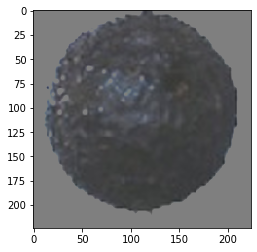

2 / 1957
1 [0. 1.]


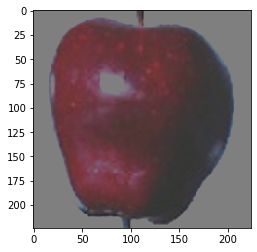

3 / 1957
0 [1. 0.]


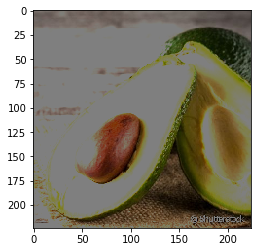

4 / 1957
0 [1. 0.]


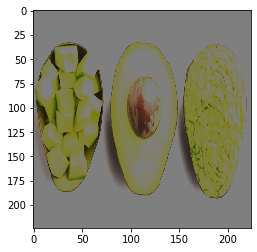

5 / 1957
0 [1. 0.]


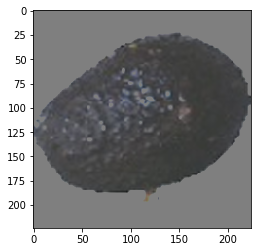

6 / 1957
0 [1. 0.]


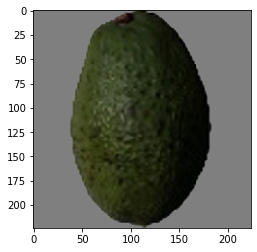

In [6]:
from random import shuffle
from math import ceil
import matplotlib.pyplot as plt
batch_size = 1
nb_class=2
# create list of batches to shuffle the data
batches_list = list(range(int(ceil(float(data_num) / batch_size))))
shuffle(batches_list)
# loop over batches
for n, i in enumerate(batches_list):
    i_s = i * batch_size  # index of the first image in this batch
    i_e = min([(i + 1) * batch_size, data_num])  # index of the last image in this batch
    # read batch images and remove training mean
    images = hdf5_file["train_set_x"][i_s:i_e, ...]
    
    if subtract_mean:
        images -= mm
    # read labels and convert to one hot encoding
    labels = hdf5_file["train_set_y"][i_s:i_e]
    labels_one_hot = np.zeros((batch_size, nb_class))
    labels_one_hot[np.arange(batch_size), labels] = 1
    print (n+1, '/', len(batches_list))
    print (labels[0], labels_one_hot[0, :])
    plt.imshow(images[0])
    plt.show()
    if n == 5:  # break after 5 batches
        break
hdf5_file.close()